# ECON 323 Final Project
## Predictive Modeling with Linear Algebra: Causalities between Covid-19 cases with Population, Age, and Gender

In May 2020, British Columbia distributed their first doses of the Covid-19 vaccines but targeted people in areas deemed as "high-transmission neighborhoods" to get the vaccine first. I didn't live in a high-transmission neighborhood but I lived exactly across the street from one; I could look down from my window and see the street that divides our neighborhoods.

The question I am trying to answer is: "What could be some factors which made the neighborhood right across the street more likely to have Covid-19 cases than where I am living?"

To test this, I took a data set issued by the German government which surveyed people who had caught Covid-19 and which have some variables which I may conduct regression analyses on. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.linalg as la

%matplotlib inline

In [2]:
df = pd.read_csv('covid_germany.csv')
df.head()

,state,county,age_group,gender,date,cases,deaths,recovered
0,Baden-Wuerttemberg,LK Alb-Donau-Kreis,00-04,F,2020-03-27,1,0,1
1,Baden-Wuerttemberg,LK Alb-Donau-Kreis,00-04,F,2020-03-28,1,0,1
2,Baden-Wuerttemberg,LK Alb-Donau-Kreis,00-04,F,2020-04-03,1,0,1
3,Baden-Wuerttemberg,LK Alb-Donau-Kreis,00-04,F,2020-10-18,1,0,1
4,Baden-Wuerttemberg,LK Alb-Donau-Kreis,00-04,F,2020-10-22,1,0,1


### Data Cleaning and Wrangling

I took the span of a bit over a year to be constant (although further research could be insightful on time series). Deaths and recovery has no concern to causality to catching Covid-19, so it is not in the dataframe. I divided areas by state as there are hundreds of different counties.

In [3]:
data = {'state': df['state'], 'age_group': df['age_group'], 'gender': df['gender'], 'cases': df['cases']}
df = pd.DataFrame.from_dict(data)
print(df.head())
print(len(df['state'].unique()))
df['state'].unique()

                state age_group gender  cases
0  Baden-Wuerttemberg     00-04      F      1
1  Baden-Wuerttemberg     00-04      F      1
2  Baden-Wuerttemberg     00-04      F      1
3  Baden-Wuerttemberg     00-04      F      1
4  Baden-Wuerttemberg     00-04      F      1
16


array(['Baden-Wuerttemberg', 'Bayern', 'Berlin', 'Brandenburg', 'Bremen',
       'Hamburg', 'Hessen', 'Mecklenburg-Vorpommern', 'Niedersachsen',
       'Nordrhein-Westfalen', 'Rheinland-Pfalz', 'Saarland', 'Sachsen',
       'Sachsen-Anhalt', 'Schleswig-Holstein', 'Thueringen'], dtype=object)

For the purposes of our data, I will choose to delete rows with missing data although they are missing at random. I recognize that this will bring bias to the parameters.

In [4]:
print(df['age_group'].isnull().values.any())
print(df['gender'].isnull().values.any())
print(df['cases'].isnull().values.any())

True
True
False


In [5]:
df = df.dropna(axis='rows')
df

,state,age_group,gender,cases
0,Baden-Wuerttemberg,00-04,F,1
1,Baden-Wuerttemberg,00-04,F,1
2,Baden-Wuerttemberg,00-04,F,1
3,Baden-Wuerttemberg,00-04,F,1
4,Baden-Wuerttemberg,00-04,F,1
...,...,...,...,...
1923869,Thueringen,80-99,M,4
1923870,Thueringen,80-99,M,2
1923871,Thueringen,80-99,M,2
1923872,Thueringen,80-99,M,3


In [6]:
print(df['age_group'].isnull().values.any())
print(df['gender'].isnull().values.any())

False
False


I divided data for age group into two for lower and upper bound, took the sum of cases where all other variables (state, gender, age_group) are the same, and I changed gender to numbers so that they can be used as input in regressions.

Gender: F - 0, M - 1

In [7]:
df1 = df.groupby(['state', 'age_group', 'gender'])

state = df['state'].unique().tolist()
age_group = df['age_group'].unique().tolist()
gender = df['gender'].unique().tolist()
print(state)
print(age_group)
print(gender)
# df1.get_group(('Baden-Wuerttemberg', '00-04', 'F')).sum()[2]

['Baden-Wuerttemberg', 'Bayern', 'Berlin', 'Brandenburg', 'Bremen', 'Hamburg', 'Hessen', 'Mecklenburg-Vorpommern', 'Niedersachsen', 'Nordrhein-Westfalen', 'Rheinland-Pfalz', 'Saarland', 'Sachsen', 'Sachsen-Anhalt', 'Schleswig-Holstein', 'Thueringen']
['00-04', '05-14', '15-34', '35-59', '60-79', '80-99']
['F', 'M']


In [8]:
def gender_num(a):
    if a == 'F':
        return 0
    else:
        return 1
    
def list_of_cases(d):
    list_of_tuples = []
    for i in state:
        for j in age_group:
            for k in gender:
                sum_case = d.get_group((i,j,k)).sum()[3]
                sum_case_tup = (i,int(j[0:2]),int(j[3:5]),gender_num(k),sum_case)
                list_of_tuples.append(sum_case_tup)
    return list_of_tuples

case_data = list_of_cases(df1)

In [9]:
case_data[0:10]

[('Baden-Wuerttemberg', 0, 4, 0, 55786),
 ('Baden-Wuerttemberg', 0, 4, 1, 59028),
 ('Baden-Wuerttemberg', 5, 14, 0, 246251),
 ('Baden-Wuerttemberg', 5, 14, 1, 265044),
 ('Baden-Wuerttemberg', 15, 34, 0, 538761),
 ('Baden-Wuerttemberg', 15, 34, 1, 525634),
 ('Baden-Wuerttemberg', 35, 59, 0, 650000),
 ('Baden-Wuerttemberg', 35, 59, 1, 594476),
 ('Baden-Wuerttemberg', 60, 79, 0, 177451),
 ('Baden-Wuerttemberg', 60, 79, 1, 174623)]

In [10]:
new_df = pd.DataFrame(case_data, columns = ['state', 'lower_bound_age_group', 'upper_bound_age_group', 'gender', 'cases'])
new_df

,state,lower_bound_age_group,upper_bound_age_group,gender,cases
0,Baden-Wuerttemberg,0,4,0,55786
1,Baden-Wuerttemberg,0,4,1,59028
2,Baden-Wuerttemberg,5,14,0,246251
3,Baden-Wuerttemberg,5,14,1,265044
4,Baden-Wuerttemberg,15,34,0,538761
...,...,...,...,...,...
187,Thueringen,35,59,1,124345
188,Thueringen,60,79,0,48378
189,Thueringen,60,79,1,44208
190,Thueringen,80,99,0,21807


In [11]:
new_df = new_df.set_index(['state'])
new_df

,lower_bound_age_group,upper_bound_age_group,gender,cases
state,,,,
Baden-Wuerttemberg,0,4,0,55786
Baden-Wuerttemberg,0,4,1,59028
Baden-Wuerttemberg,5,14,0,246251
Baden-Wuerttemberg,5,14,1,265044
Baden-Wuerttemberg,15,34,0,538761
...,...,...,...,...
Thueringen,35,59,1,124345
Thueringen,60,79,0,48378
Thueringen,60,79,1,44208


The state in Germany itself isn't important to me as I want to understand the differences between my neighborhood and the one across the street. What is important is the population within the German states, which could be a reflection of the neighborhoods around me.

Note: Due to differences in language in the dataset (in German), these are the equivalent locations in comparison to the states in the reference. Check references at the bottom to see where these numbers are from. Data is from the year 2020, the same time frame as the data set.

Bavaria is the same as Bayern

Hesse is the same as Hessen

Rhineland-Palatinate is the same as Rheinland-Pfalz

Mecklenburg-Western Pomerania is the same as Mecklenburg-Vorpommern

Thuringia is the same as Thueringen

Saxony is the same as Sachsen

Saxony-Anhalt is the same as Sachsen-Anhalt

Lower Saxony is the same as Niedersachsen

North Rhine-Westphalia is the same as Nordrhein-Westfalen

In [12]:
data1 = {'state': ['Nordrhein-Westfalen', 'Bayern', 'Baden-Wuerttemberg', 'Niedersachsen', 'Hessen', 'Rheinland-Pfalz', 'Sachsen', 'Berlin', 'Schleswig-Holstein', 'Brandenburg', 'Sachsen-Anhalt', 'Thueringen', 'Hamburg', 'Mecklenburg-Vorpommern', 'Saarland', 'Bremen'], 'population': [17925570, 13140183, 11103043, 8003421, 6293154, 4098391, 4056941, 3664088, 2910875, 2531071, 2180684, 2120237, 1852478, 1610774, 983991, 680130]}
df1 = pd.DataFrame.from_dict(data1)
df1 = df1.set_index(['state'])
df1

,population
state,
Nordrhein-Westfalen,17925570
Bayern,13140183
Baden-Wuerttemberg,11103043
Niedersachsen,8003421
Hessen,6293154
Rheinland-Pfalz,4098391
Sachsen,4056941
Berlin,3664088
Schleswig-Holstein,2910875


In [13]:
df = pd.merge(new_df, df1, on='state')
df

,lower_bound_age_group,upper_bound_age_group,gender,cases,population
state,,,,,
Baden-Wuerttemberg,0,4,0,55786,11103043
Baden-Wuerttemberg,0,4,1,59028,11103043
Baden-Wuerttemberg,5,14,0,246251,11103043
Baden-Wuerttemberg,5,14,1,265044,11103043
Baden-Wuerttemberg,15,34,0,538761,11103043
...,...,...,...,...,...
Thueringen,35,59,1,124345,2120237
Thueringen,60,79,0,48378,2120237
Thueringen,60,79,1,44208,2120237


Note: Will not do a regression for both lower and upper bound together due to multicollinearity. The purpose of separating the age groups into two parts is to do two multivariate regressions with different age inputs to see the differences.

In [14]:
def gender_name(x):
    y = []
    for i in x['gender']:
        if i == 0:
            z = 'female'
            y.append(z)
        else:
            z = 'male'
            y.append(z)
    return y
states = list(df.index.values)
lower_bound = df['lower_bound_age_group']
upper_bound = df['upper_bound_age_group']
gender = gender_name(df)
cases = df['cases']
population = df['population']

One interest Visualization that wasn't expected was that cases are higher for women in Germany than men

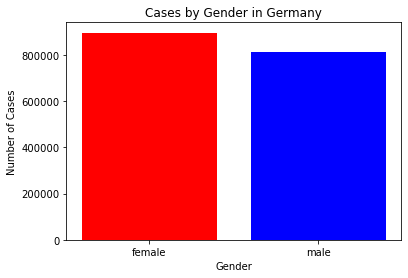

In [15]:
plt.bar(gender, cases, color = ['red', 'blue'])
plt.title('Cases by Gender in Germany')
plt.xlabel('Gender')
plt.ylabel('Number of Cases')
plt.show()
labels= ['Mortgage', 'Utilities', 'Food', 'Gas']


## Fun take on linear regression and multiple regression: Linear Algebra

### Linear Regression

For a single variable, we use linear regression where $y = c_0x^0 + c_1x^1 = c_0 + c_1x$

First we start population. We can find the linear regression for population in two ways:
1. Taking the sum of cases in each state and creating a linear regression where population explains the sum of cases
2. Don't take the sum and do a linear regression where population explains set of cases

#### Method 1

In [16]:
cases_by_state = df.groupby('state')['cases'].sum()
print(cases_by_state)
cases_by_state = list(cases_by_state)

state
Baden-Wuerttemberg        3390626
Bayern                    4488196
Berlin                     942066
Brandenburg                737370
Bremen                     177487
Hamburg                    518620
Hessen                    1640376
Mecklenburg-Vorpommern     456639
Niedersachsen             2032076
Nordrhein-Westfalen       4754296
Rheinland-Pfalz           1026135
Saarland                   290607
Sachsen                   1441328
Sachsen-Anhalt             672909
Schleswig-Holstein         617957
Thueringen                 677121
Name: cases, dtype: int64


In [17]:
df1 = df1.sort_index(axis=0)
df1['population']

state
Baden-Wuerttemberg        11103043
Bayern                    13140183
Berlin                     3664088
Brandenburg                2531071
Bremen                      680130
Hamburg                    1852478
Hessen                     6293154
Mecklenburg-Vorpommern     1610774
Niedersachsen              8003421
Nordrhein-Westfalen       17925570
Rheinland-Pfalz            4098391
Saarland                    983991
Sachsen                    4056941
Sachsen-Anhalt             2180684
Schleswig-Holstein         2910875
Thueringen                 2120237
Name: population, dtype: int64

In [18]:
pop_data = {'cases': cases_by_state, 'population': df1['population']}
df_pop = pd.DataFrame.from_dict(pop_data).reset_index(drop=True)
df_pop

,cases,population
0,3390626,11103043
1,4488196,13140183
2,942066,3664088
3,737370,2531071
4,177487,680130
5,518620,1852478
6,1640376,6293154
7,456639,1610774
8,2032076,8003421
9,4754296,17925570


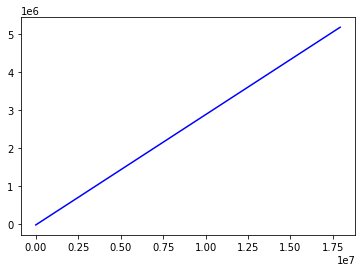

y =  -17773.950278135457 + 0.2903996536836138 t


In [19]:
y = np.array(cases_by_state)
x_pop = np.vander(np.array(df1['population']), N=2, increasing = True)

c0,c1 = la.solve(x_pop.T @ x_pop, x_pop.T @ y)

t2 = np.linspace(0,df1['population'].max(),192)

y2 = c0 + c1*t2

plt.plot(t2,y2,'blue')
plt.show()

print('y = ',c0, '+', c1, 't')

As we can see from the results,
- Cases are higher if there are more females
- Cases are lower with increase in age
- Cases are higher with increase in population

Now let's try to put these variables in another format of linear regression to see how they fit

Note: Because population was taken in another format

<AxesSubplot:xlabel='population', ylabel='cases'>

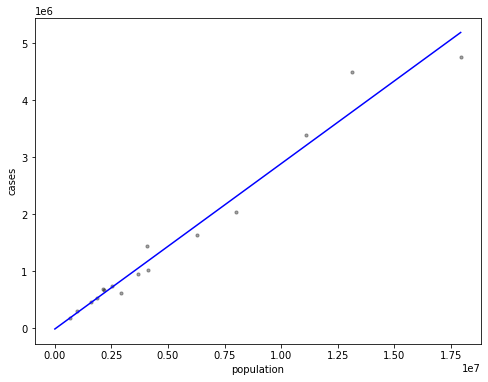

In [20]:

def var_scatter_pop(df_pop, ax=None, var='population'):
    if ax is None:
        _, ax = plt.subplots(figsize=(8, 6))
    df_pop.plot.scatter(x=var , y='cases', alpha=0.35, s=10, ax=ax, c='black')
    plt.plot(t2,y2,'blue')

    return ax
var_scatter_pop(df_pop)


#### Method 2:

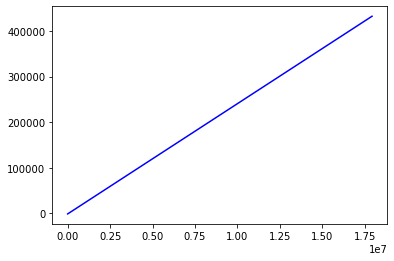

y =  -1481.1625231779547 + 0.02419997114030115 t


In [21]:
y = np.array(df['cases'])
x_pop1 = np.vander(np.array(df['population']), N=2, increasing = True)

c0,c1 = la.solve(x_pop1.T @ x_pop1, x_pop1.T @ y)

t10 = np.linspace(0,df['population'].max(),192)

y10 = c0 + c1*t10

plt.plot(t10,y10,'blue')
plt.show()

print('y = ',c0, '+', c1, 't')

<AxesSubplot:xlabel='population', ylabel='cases'>

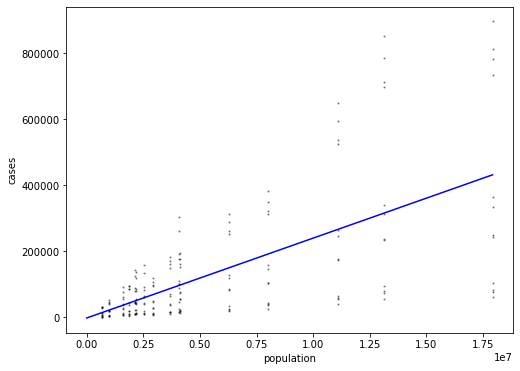

In [22]:
def var_scatter_pop1(df, ax=None, var='population'):
    if ax is None:
        _, ax = plt.subplots(figsize=(8, 6))
    df.plot.scatter(x=var , y='cases', alpha=0.35, s=1.5, ax=ax, c='black')
    plt.plot(t10,y10,'blue')

    return ax
var_scatter_pop1(df)

We can see signs of heteroskedasticity by the patterns of the errors in the scatterplot above. Thus, we try to take the log of y to attempt a better fit.

In [23]:
y = np.log(df["cases"])
df["log_cases"] = y
y.head()

state
Baden-Wuerttemberg    10.929278
Baden-Wuerttemberg    10.985767
Baden-Wuerttemberg    12.414107
Baden-Wuerttemberg    12.487651
Baden-Wuerttemberg    13.197027
Name: cases, dtype: float64

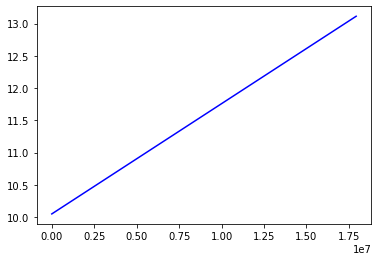

y =  10.047672170428715 + 1.710445288521163e-07 t


In [24]:
y = np.array(df['log_cases'])
x_pop1 = np.vander(np.array(df['population']), N=2, increasing = True)

c0,c1 = la.solve(x_pop1.T @ x_pop1, x_pop1.T @ y)

t11 = np.linspace(0,df['population'].max(),192)

y11 = c0 + c1*t11

plt.plot(t11,y11,'blue')
plt.show()

print('y = ',c0, '+', c1, 't')

<AxesSubplot:xlabel='population', ylabel='log_cases'>

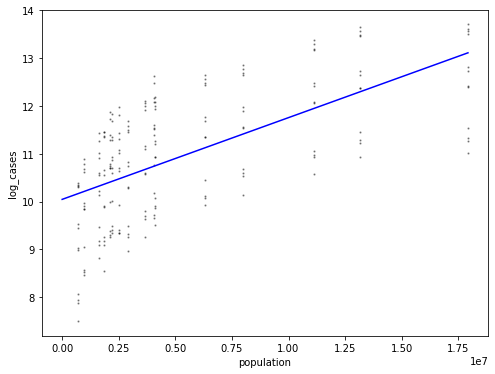

In [25]:
def var_scatter_pop2(df, ax=None, var='population'):
    if ax is None:
        _, ax = plt.subplots(figsize=(8, 6))
    df.plot.scatter(x=var , y='log_cases', alpha=0.35, s=1.5, ax=ax, c='black')
    plt.plot(t11,y11,'blue')

    return ax
var_scatter_pop2(df)

A much better fit! Let's keep things consistent and also take the log of y for the other two variables

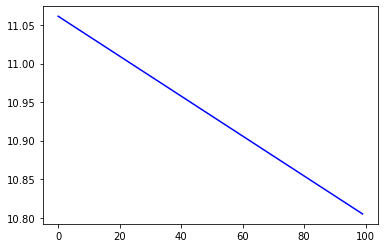

y =  11.06139863698896 + -0.0025904978796096136 t


In [26]:
y = np.array(df['log_cases'])
x_age = np.vander(np.array(df['upper_bound_age_group']), N=2, increasing = True)

c0,c1 = la.solve(x_age.T @ x_age, x_age.T @ y)

t20 = np.linspace(0,df['upper_bound_age_group'].max(),192)

y20 = c0 + c1*t20

plt.plot(t20,y20,'blue')
plt.show()

print('y = ',c0, '+', c1, 't')

<AxesSubplot:xlabel='upper_bound_age_group', ylabel='log_cases'>

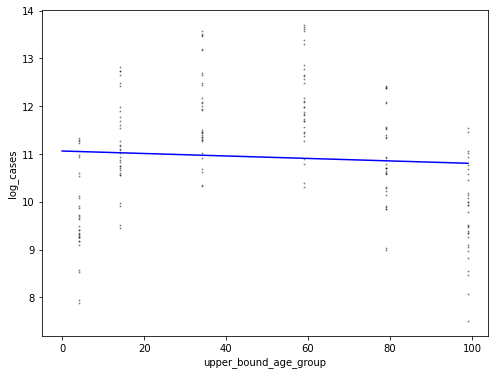

In [27]:
def var_scatter_age20(df, ax=None, var='upper_bound_age_group'):
    if ax is None:
        _, ax = plt.subplots(figsize=(8, 6))
    df.plot.scatter(x=var , y='log_cases', alpha=0.35, s=1, ax=ax, c='black')
    plt.plot(t20,y20,'blue')

    return ax
var_scatter_age20(df)

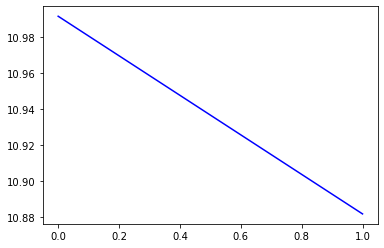

y =  10.991418251317578 + -0.10959052439296595 t


In [28]:
y = np.array(df['log_cases'])
x_gender = np.vander(np.array(df['gender']), N=2, increasing = True)

c0,c1 = la.solve(x_gender.T @ x_gender, x_gender.T @ y)

t00 = np.linspace(0,df['gender'].max(),192)

y00 = c0 + c1*t00

plt.plot(t00,y00,'blue')
plt.show()

print('y = ',c0, '+', c1, 't')

<AxesSubplot:xlabel='gender', ylabel='log_cases'>

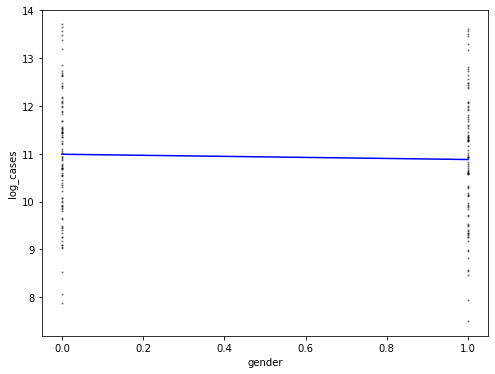

In [29]:
def var_scatter_gender0(df, ax=None, var='gender'):
    if ax is None:
        _, ax = plt.subplots(figsize=(8, 6))
    df.plot.scatter(x=var , y='log_cases', alpha=0.35, s=1.5, ax=ax, c='black')
    plt.plot(t00,y00,'blue')

    return ax
var_scatter_gender0(df)

### Multiple Regression

Following this formula:
$$
\underbrace{\begin{bmatrix} \log(\text{cases}_1) \\ \log(\text{cases}_2) \\ \vdots \\ \log(\text{cases}_N)\end{bmatrix}}_Y = \underbrace{\begin{bmatrix} 1 & \text{population}_1 & \text{age}_1 & \text{gender}_1 \\ 1 & \text{population}_2 & \text{age}_2 & \text{gender}_2 \\ \vdots & \vdots & \vdots \\ 1 & \text{population}_N & \text{age}_N & \text{gender}_N \end{bmatrix}}_{X} \underbrace{\begin{bmatrix} \beta_0 \\ \beta_1 \\ \beta_2 \end{bmatrix}}_{\beta} + \epsilon
$$

Let's do some linear algebra!

First, we'll start off with the upper bound for age

In [30]:
N = len(df['cases'])
y = np.array(df['log_cases'])
x = np.column_stack((np.ones(N), np.array(df['population']), np.array(df['upper_bound_age_group']), np.array(df['gender'])))

c0,c1,c2,c3 = la.solve(x.T @ x, x.T @ y)

t_pop = np.linspace(0,df['population'].max(),N)
t_age = np.linspace(0,df['upper_bound_age_group'].max(),N)
t_gen = np.linspace(0,df['gender'].max(),N)

y_mult = c0 + c1*t_pop + c2*t_age + c3*t_gen


print('y = ',c0, '+', c1, 'population', '+', c2, 'age', '+', c3, 'gender')

y =  10.22724308049305 + 1.7104452885211736e-07 population + -0.0025904978796097 age + -0.1095905243929612 gender


Now, we'll do the lower bound for age

In [31]:
N = len(df['cases'])
y = np.array(df['log_cases'])
x1 = np.column_stack((np.ones(N), np.array(df['population']), np.array(df['lower_bound_age_group']), np.array(df['gender'])))

c0,c1,c2,c3 = la.solve(x1.T @ x1, x1.T @ y)

t_pop1 = np.linspace(0,df['population'].max(),N)
t_age1 = np.linspace(0,df['lower_bound_age_group'].max(),N)
t_gen1 = np.linspace(0,df['gender'].max(),N)

y_mult1 = c0 + c1*t_pop1 + c2*t_age1 + c3*t_gen1


print('y = ',c0, '+', c1, 'population', '+', c2, 'age', '+', c3, 'gender')

y =  10.35014797909744 + 1.7104452885211736e-07 population + -0.007620939891454056 age + -0.1095905243929612 gender


## Conclusion

In the end, I can say that I now somewhat have an idea of the number of Covid-19 cases based on factors such as population, age, and gender (proportion of people within the population under a specified gender). 

I can't say that my model is very accurate, I would have to run R-squared tests for that. I did have fun learning how to use matrices and vectors to do regressions; a new take on data sciences that is different from using packages. It was also very interesting to do data wrangling from scratch. 

## Limitations

- Didn't take time to be a variable
- Could find more variables that minimize errors
- Taking R-Squared to find correlation between inputs with output (using linear algebra)
- MNAR inputs deleted
- Use more regression analyses (needed more understanding of how to do using linear algebra)

## References:
https://www.mappr.co/thematic-maps/germany-population-states/